In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

repo_path = "/content/drive/MyDrive/Tree_Species_DataSet"  # Adjust if cloned to a different name
print("Contents:", os.listdir(repo_path))

Contents: ['kesudo', 'amla', 'garmalo', '.git', 'cactus', 'bili', 'asopalav', 'banyan', 'champa', 'bamboo', 'babul', 'coconut', 'jamun', 'saptaparni', 'neem', 'mango', 'sugarcane', 'gunda', 'khajur', 'pipal', 'gulmohor', 'nilgiri', 'sitafal', 'other', 'vad', 'motichanoti', 'simlo', 'kanchan', 'shirish', 'pilikaren', 'sonmahor']


In [6]:
class_dirs = os.listdir(repo_path)
print(f"Number of classes: {len(class_dirs)}")

Number of classes: 31


In [7]:
import glob

image_paths = []
labels = []

for class_name in os.listdir(repo_path):
    class_folder = os.path.join(repo_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

print(f"Total images: {len(image_paths)}")

Total images: 1605


In [8]:
import pandas as pd

class_counts = {cls: len(os.listdir(os.path.join(repo_path, cls))) for cls in class_dirs}
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
print(class_counts_df.sort_values('Image Count', ascending=False).head())
print("shape: ",class_counts_df.shape)

        Image Count
other           150
amla             50
kesudo           50
cactus           50
bili             50
shape:  (31, 1)


Error opening image /content/drive/MyDrive/Tree_Species_DataSet/.git/HEAD: cannot identify image file '/content/drive/MyDrive/Tree_Species_DataSet/.git/HEAD'


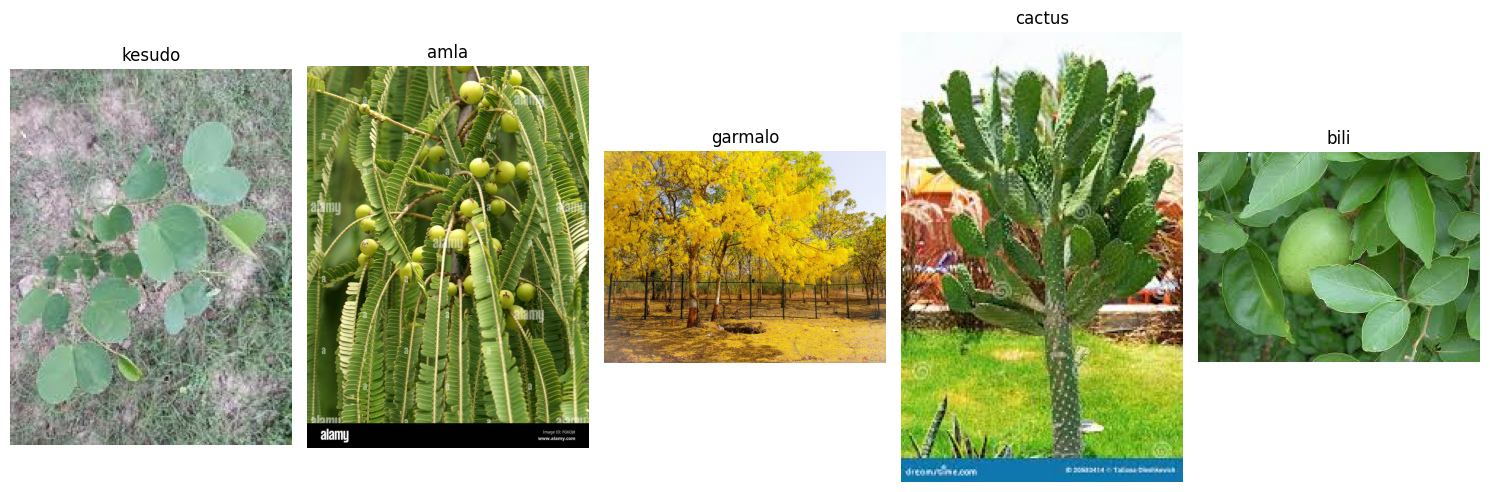

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(repo_path, class_dirs, n=5):
    plt.figure(figsize=(15, 10))
    count = 0

    for class_dir in class_dirs:
        class_path = os.path.join(repo_path, class_dir)
        # Skip if it's not a directory
        if not os.path.isdir(class_path):
            continue

        # Get image files only (not folders, not hidden files)
        img_files = [f for f in os.listdir(class_path)
                     if os.path.isfile(os.path.join(class_path, f))
                     and not f.startswith('.')]

        if not img_files:
            continue

        img_path = os.path.join(class_path, img_files[0])

        try:
            img = Image.open(img_path)
            plt.subplot(1, n, count + 1)
            plt.imshow(img)
            plt.title(class_dir)
            plt.axis('off')
            count += 1

            if count == n:
                break
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Example usage:
show_sample_images(repo_path, class_dirs)


In [18]:
import os
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm  # progress bar

repo_path = '/content/drive/MyDrive/Tree_Species_DataSet'  # adjust if needed
image_shapes = []

# Function to safely open and get image size
def get_image_size(img_path):
    try:
        if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            with Image.open(img_path) as img:
                return img.size
    except Exception:
        return None
    return None

# Loop through each image file in each class
all_image_paths = []
for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        all_image_paths.append(img_path)

# Optional: limit number of images for quick test
# all_image_paths = all_image_paths[:1000]

# Use ThreadPoolExecutor with timeout for faster processing and skip stuck files
with ThreadPoolExecutor(max_workers=4) as executor:
    for future in tqdm(executor.map(get_image_size, all_image_paths), total=len(all_image_paths)):
        if future:
            image_shapes.append(future)

# Create DataFrame and show result
shapes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(shapes_df.head())


100%|██████████| 1605/1605 [00:51<00:00, 30.94it/s]

   Width  Height
0    194     259
1    194     259
2    249     203
3    225     225
4    188     268


In [19]:
print(shapes_df.describe())

             Width       Height
count  1600.000000  1600.000000
mean    312.623125   269.821875
std     296.220501   278.014229
min     141.000000   128.000000
25%     225.000000   183.000000
50%     259.000000   200.000000
75%     275.000000   259.000000
max    4000.000000  4032.000000


In [21]:
import os
import hashlib
from collections import defaultdict

hashes = defaultdict(list)

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                    hashes[file_hash].append(img_path)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Filter duplicates
duplicates = {h: files for h, files in hashes.items() if len(files) > 1}
print("Duplicate image sets found:", len(duplicates))


Duplicate image sets found: 82


In [22]:
corrupt_images = []

for class_dir in class_dirs:
    for img_file in os.listdir(os.path.join(repo_path, class_dir)):
        img_path = os.path.join(repo_path, class_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            corrupt_images.append(img_path)

print("Corrupted images:", len(corrupt_images))

Corrupted images: 5


Duplicate set 1:


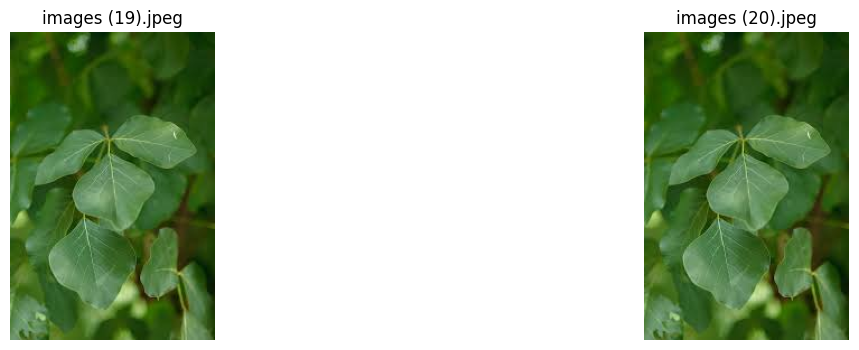

Duplicate set 2:


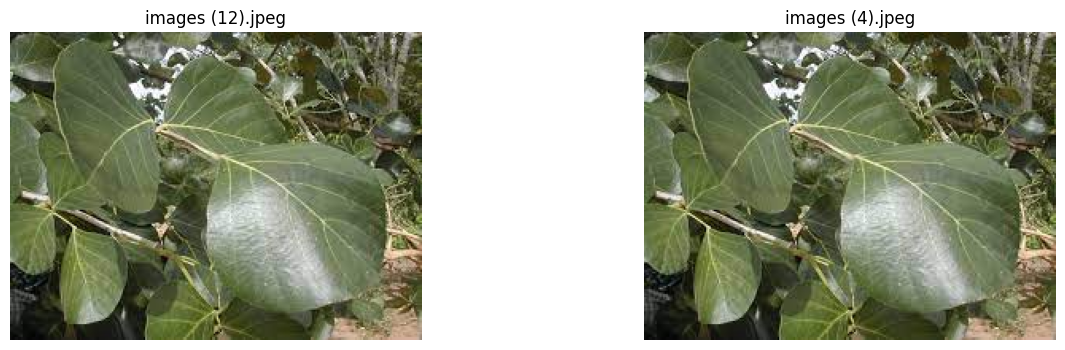

Duplicate set 3:


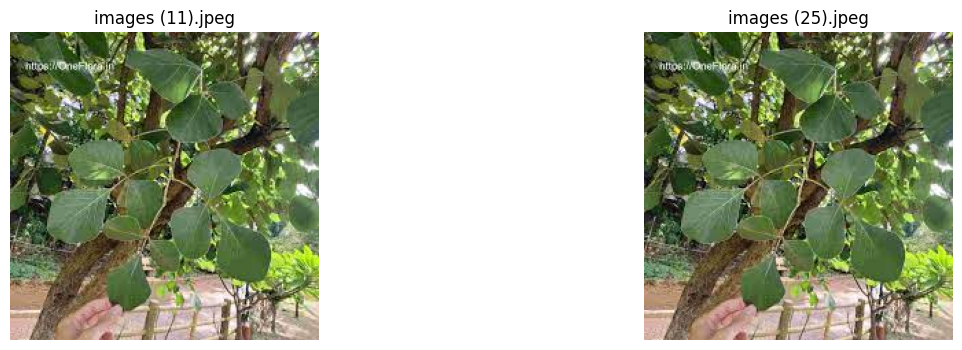

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

def show_duplicate_sets(duplicates, sets_to_display=3):
    shown = 0
    for hash_val, dup_paths in duplicates.items():
        if shown >= sets_to_display:
            break
        print(f"Duplicate set {shown + 1}:")
        plt.figure(figsize=(15, 4))
        for i, img_path in enumerate(dup_paths):
            try:
                img = Image.open(img_path)
                plt.subplot(1, len(dup_paths), i+1)
                plt.imshow(img)
                plt.title(os.path.basename(img_path))
                plt.axis('off')
            except:
                continue
        plt.show()
        shown += 1

show_duplicate_sets(duplicates, sets_to_display=3)

In [24]:
import os

removed_count = 0

for dup_list in duplicates.values():
    # Keep the first, delete rest
    for img_path in dup_list[1:]:
        try:
            os.remove(img_path)
            removed_count += 1
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

print(f"✅ Removed {removed_count} duplicate images.")

✅ Removed 86 duplicate images.


In [30]:
import os
import hashlib
from collections import defaultdict

hashes = defaultdict(list)

# Loop through each class directory
for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Check if it's a valid image file
        if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                    hashes[file_hash].append(img_path)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Find duplicates
duplicates = {h: files for h, files in hashes.items() if len(files) > 1}

# Print results
print("🔁 Duplicates found:", len(duplicates))
for i, (h, files) in enumerate(duplicates.items(), 1):
    print(f"\nDuplicate Set {i}:")
    for f in files:
        print(" -", f)


🔁 Duplicates found: 0


In [31]:
import os
from PIL import Image, UnidentifiedImageError

def remove_corrupt_images(base_path, class_dirs):
    removed_count = 0

    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Ensure it's a file and has a valid image extension
            if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image integrity
                except (IOError, UnidentifiedImageError, SyntaxError) as e:
                    print(f"🗑️ Removing corrupt image: {img_path}")
                    os.remove(img_path)
                    removed_count += 1

    print(f"\n✅ Total corrupt images removed: {removed_count}")

# Example usage
remove_corrupt_images(repo_path, class_dirs)



✅ Total corrupt images removed: 0


In [32]:
from PIL import Image
import pandas as pd

# Gather image info
image_info = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_info.append({
                    'path': img_path,
                    'width': width,
                    'height': height,
                    'class': class_dir
                })
        except:
            continue

df_sizes = pd.DataFrame(image_info)

# Define thresholds
small_imgs = df_sizes[(df_sizes['width'] < 150) | (df_sizes['height'] < 150)]
large_imgs = df_sizes[(df_sizes['width'] > 1000) | (df_sizes['height'] > 2000)]

print(f"🔻 Very small images: {len(small_imgs)}")
print(f"🔺 Very large images: {len(large_imgs)}")

🔻 Very small images: 20
🔺 Very large images: 40


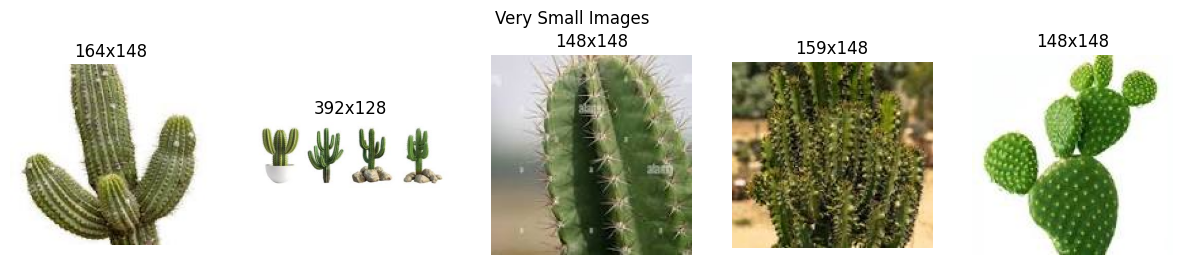

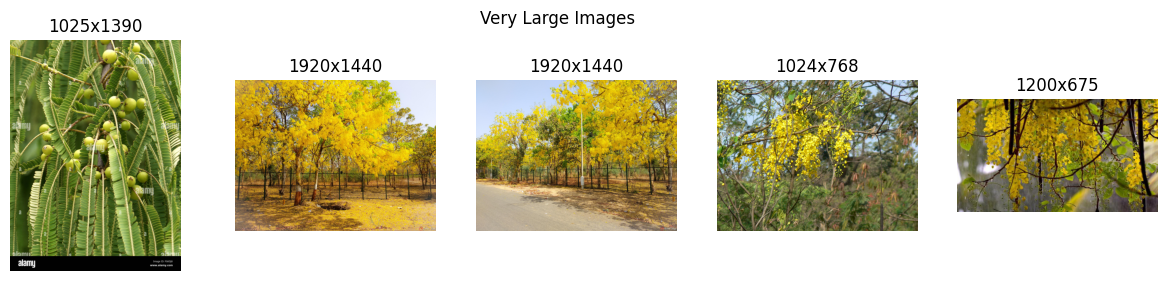

In [33]:
def show_images(df_subset, title, n=5):
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(df_subset.head(n).iterrows()):
        img = Image.open(row['path'])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{row['width']}x{row['height']}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(small_imgs, "Very Small Images")
show_images(large_imgs, "Very Large Images")

In [34]:
import os

# Combine both sets
outliers = pd.concat([small_imgs, large_imgs])

# Remove them
removed_count = 0
for path in outliers['path']:
    try:
        os.remove(path)
        removed_count += 1
    except Exception as e:
        print(f"Failed to remove {path}: {e}")

print(f"🗑️ Removed {removed_count} outlier images (small + large).")

🗑️ Removed 60 outlier images (small + large).


In [35]:
# Recalculate sizes
image_info = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_info.append({
                    'path': img_path,
                    'width': width,
                    'height': height,
                    'class': class_dir
                })
        except:
            continue

df_sizes = pd.DataFrame(image_info)
print(df_sizes[['width', 'height']].describe())

             width       height
count  1454.000000  1454.000000
mean    275.872765   239.044704
std     117.507849   117.197342
min     150.000000   150.000000
25%     225.000000   183.000000
50%     259.000000   198.000000
75%     275.000000   256.000000
max    1000.000000  1247.000000


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1177 images belonging to 31 classes.
Found 277 images belonging to 31 classes.


In [37]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,538 (16.09 MB)

 Trainable params: 167,967 (656.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [38]:
EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.0420 - loss: 3.4861 - val_accuracy: 0.0903 - val_loss: 3.4020
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.0830 - loss: 3.4181 - val_accuracy: 0.0903 - val_loss: 3.4000
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.0781 - loss: 3.4108 - val_accuracy: 0.0903 - val_loss: 3.3843
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.0926 - loss: 3.3916 - val_accuracy: 0.0903 - val_loss: 3.3887
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.0845 - loss: 3.3966 - val_accuracy: 0.0903 - val_loss: 3.3808
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.0817 - loss: 3.3930 - val_accuracy: 0.0903 - val_loss: 3.3823
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.0793 - loss: 3.4017 - val_accuracy: 0.0903 - val_loss: 3.3817
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.0742 - loss: 3.4017 - val_accuracy: 0.0903 - v

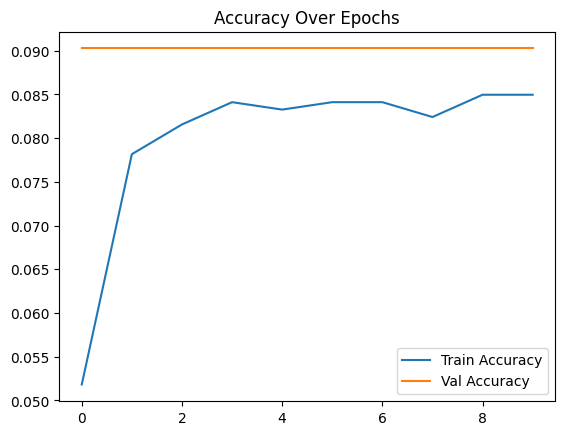

In [39]:
# Plot accuracy/loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

# Save model
model.save("tree_species_model.h5")

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image properties
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Number of output classes
num_classes = train_generator.num_classes

# Build a basic CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
EPOCHS = 10
history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Save the model
model_cnn.save('basic_cnn_tree_species.h5')
print("✅ Basic CNN model saved as 'basic_cnn_tree_species.h5'")

Found 1177 images belonging to 31 classes.
Found 277 images belonging to 31 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.0600 - loss: 3.8050 - val_accuracy: 0.1047 - val_loss: 3.2302
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.1159 - loss: 3.2645 - val_accuracy: 0.1047 - val_loss: 3.1309
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.1057 - loss: 3.1520 - val_accuracy: 0.1372 - val_loss: 2.9432
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.1427 - loss: 3.0153 - val_accuracy: 0.1949 - val_loss: 2.9297
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.1778 - loss: 2.9240 - val_accuracy: 0.2058 - val_loss: 2.7912
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.1955 - loss: 2.8626 - val_accuracy: 0.2202 - val_loss: 2.7937
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.1755 - loss: 2.8422 - val_accuracy: 0.2347 - val_loss: 2.6723
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.2033 - loss: 2.7257 - val_accuracy: 0.2744 - v

✅ Basic CNN model saved as 'basic_cnn_tree_species.h5'


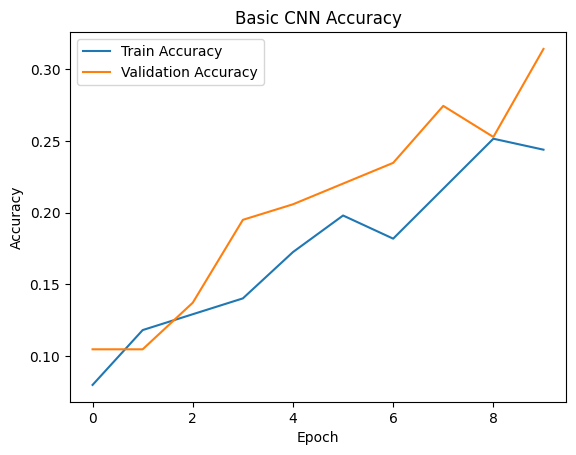

In [41]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("Basic CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()